In [1]:
import clip
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw

model, preprocess = clip.load("ViT-B/16")
model.init_adapters()

In [2]:
from RefcocogDataset import RefcocogDataset
from torch.utils.data import DataLoader

train_dataset = RefcocogDataset("./refcocog", split="train", transform=preprocess)
val_dataset = RefcocogDataset("./refcocog", split="val", transform=preprocess)
test_dataset = RefcocogDataset("./refcocog", split="test", transform=preprocess)

print(len(train_dataset), len(val_dataset), len(test_dataset))

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

80512 4896 9602


In [3]:
def visualize_sample(sample, bbox, idx=0):
    print(f"Sentence: {sample['sentences'][idx]}")
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(sample['image'][idx].permute(1, 2, 0))
    axes[1].imshow(bbox['gt'][idx])
    plt.tight_layout()
    plt.show()

def build_probability_map(patch_tokens, out_text):
    patch_tokens = patch_tokens.squeeze(0)[1:]
    map = torch.zeros(196)

    for i, token in enumerate(patch_tokens):
        map[i] = 1 - torch.cosine_similarity(token, out_text).item() # 1 - ... temporary fix
    
    map = torch.sigmoid(map)
    map = map.reshape(14, 14)
    return map

def visualize_loss(map, gt, loss_map):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(map)
    axs[1].imshow(gt)
    axs[2].imshow(loss_map.reshape(14, 14))
    plt.tight_layout()
    plt.show()

/Users/francesco/Library/Python/3.9/lib/python/site-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Sentence: a photo of a a brown bull in front of feeding tub


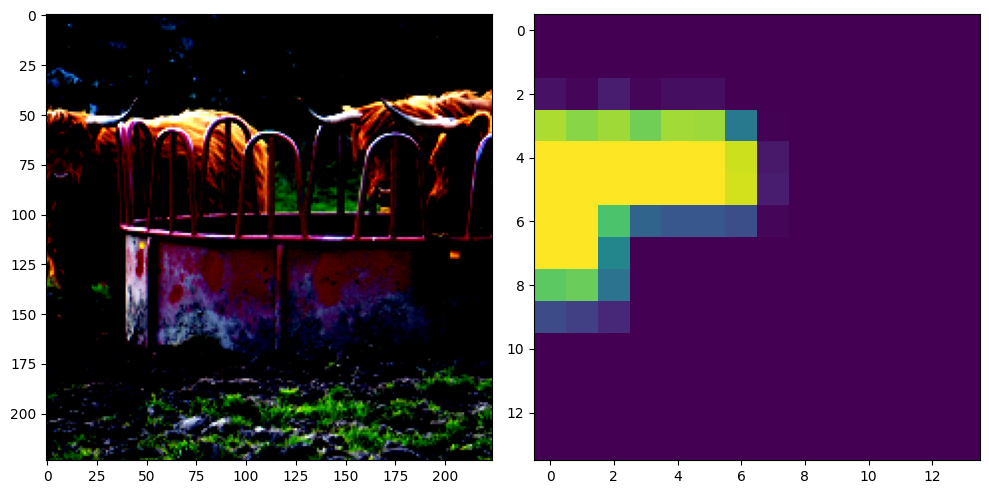

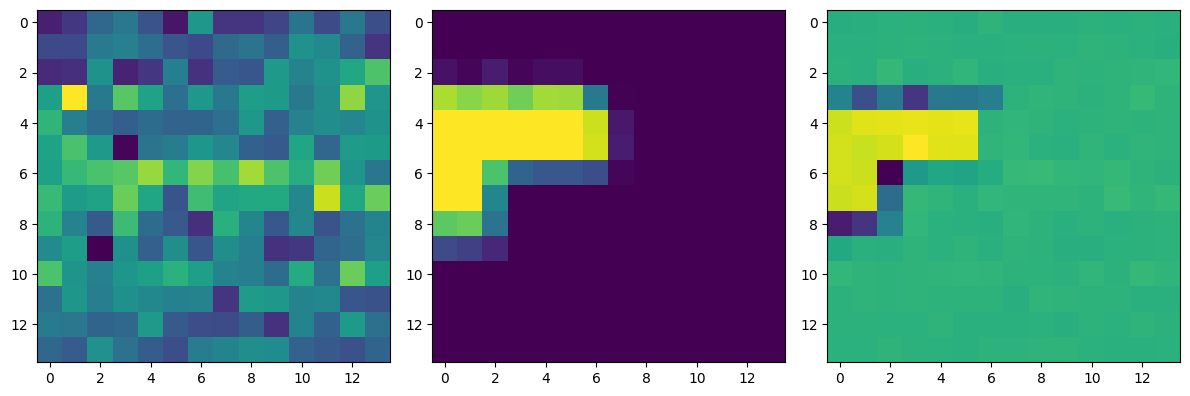

In [4]:
def loss(map, gt, gamma=1):
    map = map.reshape(-1)
    gt = gt.reshape(-1)
    abs = torch.abs(map - gt)
    log = -torch.log(1-abs)
    
    # amplify the error of pixel that should belong to the object
    log = log*(gt*gamma+1)

    loss = torch.sum(log)
    return loss, log

for sample, bbox in train_loader:
    idx = 7

    visualize_sample(sample, bbox, idx)

    out_image, out_text, patch_tokens, text_tokens = model.encode(sample['image'][idx].unsqueeze(0), clip.tokenize(sample['sentences'][idx]))
    out_image, out_text = patch_tokens[0, 0].unsqueeze(0), text_tokens[0, -1].unsqueeze(0)
    
    # print(f'Similarity: {torch.cosine_similarity(out_image, out_text).item():.4f}')
    
    map = build_probability_map(patch_tokens, out_text)
    gt = bbox['gt'][idx]/255

    error, loss_map = loss(map, gt, gamma=3.4)

    visualize_loss(map, bbox['gt'][idx], loss_map)
    
    break

In [7]:
for param in model.parameters():
    param.requires_grad = False

for param in model.postfusion_adapter.parameters():
    param.requires_grad = True

for param in model.prefusion_adapters.parameters():
    param.requires_grad = True

for param in model.backbone_adapters_MHSA_vis.parameters():
    param.requires_grad = True

for param in model.backbone_adapters_MHSA_txt.parameters():
    param.requires_grad = True

for param in model.backbone_adapters_MLP_vis.parameters():
    param.requires_grad = True

for param in model.backbone_adapters_MLP_txt.parameters():
    param.requires_grad = True